Stopped by user.


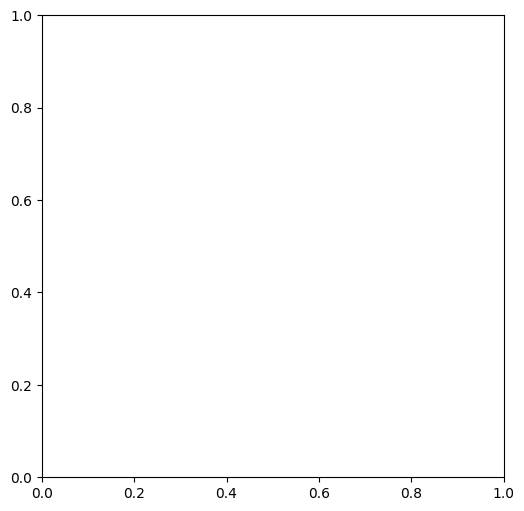

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

def classify_coin(radius):
    if 10 <= radius < 18:
        return 'PHP 0.01', 0.01
    elif 18 <= radius < 25:
        return 'PHP 0.25', 0.25
    elif 25 <= radius < 33:
        return 'PHP 1', 1
    elif 33 <= radius < 40:
        return 'PHP 5', 5
    elif 40 <= radius < 50:
        return 'PHP 10', 10
    else:
        return None, 0

cap = cv2.VideoCapture(1)  

if not cap.isOpened():
    print("Cannot open camera")
    exit()

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        frame = cv2.resize(frame, (640, 480))
        output = frame.copy()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        blurred = cv2.medianBlur(gray, 7)

        circles = cv2.HoughCircles(
            blurred,
            cv2.HOUGH_GRADIENT,
            dp=1.2,
            minDist=30,
            param1=50,
            param2=30,
            minRadius=10,
            maxRadius=50
        )

        coin_count = 0
        total_value = 0.0

        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")
            for (x, y, r) in circles:
                label, value = classify_coin(r)
                if value > 0:
                    coin_count += 1
                    total_value += value
                    cv2.circle(output, (x, y), r, (0, 255, 0), 2)
                    cv2.putText(output, f"{label}", (x - 40, y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        cv2.putText(output, f"Total coins: {coin_count}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
        cv2.putText(output, f"Total value: PHP {total_value:.2f}", (10, 70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Coins: {coin_count} | Total: PHP {total_value:.2f}")
        plt.show()

        clear_output(wait=True)

except KeyboardInterrupt:
    print("Stopped by user.")

finally:
    cap.release()
